In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import seaborn as sns
from IPython.display import display, Math
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

import sys
import os
sys.path.append(os.path.abspath('../utils'))
from Perturbe_Algs import Attacks

np.random.seed(10)

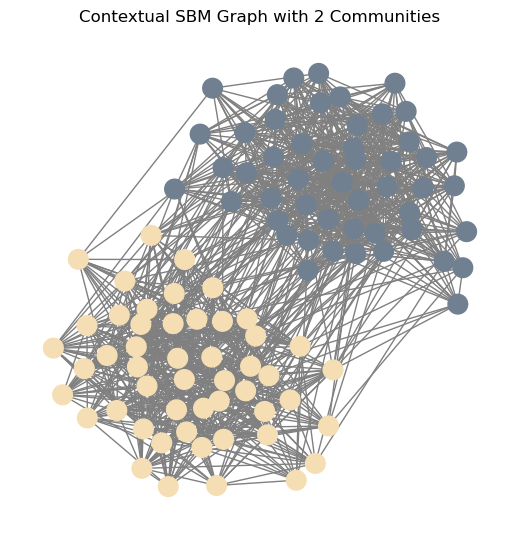

In [2]:

# Create a contextual stochastic block model (SBM) graph with two communities

n = [50,50]
N = np.sum(n)
p_in = 0.4
p_out = 0.05
p_matrix = np.full((2,2),p_out)
np.fill_diagonal(p_matrix,p_in)
# Greate SBM graph
G = nx.stochastic_block_model(n, p_matrix, seed=1)
for u in range(N):
        if u< n[1]:
            G.nodes[u]['label'] = 1
        else:
            G.nodes[u]['label'] = -1
# Create node feature x_i = \pm c + N(0,1)
d = 100
for u in G.nodes():
    G.nodes[u]['feature'] =  2*G.nodes[u]['label'] + np.random.normal(0, 1,d)

# Visualize graph
colors = ['#F5DEB3', '#708090']
cmap = mcolors.ListedColormap(colors)
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, seed=1)  # Layout for visualization
node_colors = [G.nodes[node]['label'] for node in G.nodes()]  # Color by label
nx.draw(G, pos, node_color=node_colors, cmap=cmap, node_size=200, edge_color='gray', with_labels=False, alpha =1)
plt.title("Contextual SBM Graph with 2 Communities")
plt.show()

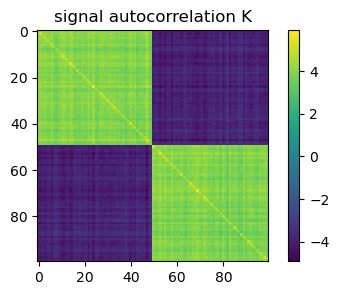

Perturbe  20 edges


In [3]:

m = 20
J = np.ones((N,N))
I = np.eye(N)
A_SBM = nx.adjacency_matrix(G).todense()
X = np.zeros((N,d))
for u in range(N):
        X[u,:] =  G.nodes[u]['feature']

K_cSBM = X@X.T/d

plt.figure(figsize = (5,3))
plt.imshow(K_cSBM,interpolation='None')
plt.colorbar()
plt.title('signal autocorrelation K')
plt.show()

A = torch.tensor(A_SBM).type(torch.double)
n = A.shape[0]
K = torch.tensor(K_cSBM).type(torch.double)
X = torch.tensor(X).type(torch.double)
Knp = K.cpu().numpy()

print(f'Perturbe {m: d} edges')
alpha = 1
max_iter = 100
mute = True


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Attack_GCN = Attacks(A, K, m, alpha, max_iter,filter = 'adj_norm').to(device)
A_pgd_wst = Attack_GCN.pgd_wst()
A_random = Attack_GCN.randomAttack()
A_pgd_avg = Attack_GCN.pgd_avg()



Using device: cpu


In [5]:

def gcn_relu(A, X, W1, W2, W3, W4, W5):
  """
  Applies a five-layer graph convolution operation.
  Args:
    A: Adjacency matrix (N x N).
    X: Node features (N x d).
    W1: Weight matrix for the first layer (d x 10).
    W2: Weight matrix for the second layer (10 x 10).

  Returns:
    The outputs of each GCN layer (N x 10).
  """
  # Calculate degree matrix
  D = torch.diag(torch.sum(A, dim=1))  
  # Calculate inverse square root of degree matrix
  D_inv_sqrt = torch.pow(D, -0.5)  
  D_inv_sqrt = torch.nan_to_num(D_inv_sqrt, posinf=0, neginf=0) 
  # Calculate normalized adjacency matrix
  A_norm = torch.matmul(torch.matmul(D_inv_sqrt, A), D_inv_sqrt)  
  # First layer
  hidden1 = torch.relu(torch.matmul(torch.matmul(A_norm, X), W1))
  hidden2 = torch.relu(torch.matmul(torch.matmul(A_norm, hidden1), W2))
  hidden3 = torch.relu(torch.matmul(torch.matmul(A_norm, hidden2),W3))
  hidden4 = torch.relu(torch.matmul(torch.matmul(A_norm, hidden3),W4))
  hidden5 = torch.relu(torch.matmul(torch.matmul(A_norm, hidden4),W5))
  return hidden1, hidden2, hidden3, hidden4, hidden5



def gcn_sigmoid(A, X, W1, W2, W3, W4, W5):
  """
  Applies a five-layer graph convolution operation.
  Args:
    A: Adjacency matrix (N x N).
    X: Node features (N x d).
    W1: Weight matrix for the first layer (d x 10).
    W2: Weight matrix for the second layer (10 x 10).

  Returns:
    The output of each GCN layer (N x 10).
  """
  # Calculate degree matrix
  D = torch.diag(torch.sum(A, dim=1))  
  # Calculate inverse square root of degree matrix
  D_inv_sqrt = torch.pow(D, -0.5)  
  D_inv_sqrt = torch.nan_to_num(D_inv_sqrt, posinf=0, neginf=0) 
  # Calculate normalized adjacency matrix
  A_norm = torch.matmul(torch.matmul(D_inv_sqrt, A), D_inv_sqrt)  
  # First layer
  hidden1 = torch.sigmoid(torch.matmul(torch.matmul(A_norm, X), W1))
  hidden2 = torch.sigmoid(torch.matmul(torch.matmul(A_norm, hidden1), W2))
  hidden3 = torch.sigmoid(torch.matmul(torch.matmul(A_norm, hidden2),W3))
  hidden4 = torch.sigmoid(torch.matmul(torch.matmul(A_norm, hidden3),W4))
  hidden5 = torch.sigmoid(torch.matmul(torch.matmul(A_norm, hidden4),W5))
  return hidden1, hidden2, hidden3, hidden4, hidden5



In [6]:
num_repetitions = 200

# Store results for gcn_sigmoid
X1p_random_sigmoid = []
X1p_pgd_wst_sigmoid = []
X1p_pgd_avg_sigmoid = []

X2p_random_sigmoid = []
X2p_pgd_wst_sigmoid = []
X2p_pgd_avg_sigmoid = []

X3p_random_sigmoid = []
X3p_pgd_wst_sigmoid = []
X3p_pgd_avg_sigmoid = []

X4p_random_sigmoid = []
X4p_pgd_wst_sigmoid = []
X4p_pgd_avg_sigmoid = []

X5p_random_sigmoid = []
X5p_pgd_wst_sigmoid = []
X5p_pgd_avg_sigmoid = []

# Store results for gcn_relu
X1p_random_relu = []
X1p_pgd_wst_relu = []
X1p_pgd_avg_relu = []

X2p_random_relu = []
X2p_pgd_wst_relu = []
X2p_pgd_avg_relu = []

X3p_random_relu = []
X3p_pgd_wst_relu = []
X3p_pgd_avg_relu = []

X4p_random_relu = []
X4p_pgd_wst_relu = []
X4p_pgd_avg_relu = []

X5p_random_relu = []
X5p_pgd_wst_relu = []
X5p_pgd_avg_relu = []

for _ in range(num_repetitions):
    # Generate random matrices W1, W2, W3, W4, W5
    W1 = torch.randn(d, 10, device=device, dtype=torch.double)
    W2 = torch.randn(10, 10, device=device, dtype=torch.double)
    W3 = torch.randn(10, 10, device=device, dtype=torch.double)
    W4 = torch.randn(10, 10, device=device, dtype=torch.double)
    W5 = torch.randn(10, 10, device=device, dtype=torch.double)

    # Compute original outputs for gcn_sigmoid
    original_hidden1_sigmoid, original_hidden2_sigmoid, original_hidden3_sigmoid, original_hidden4_sigmoid, original_hidden5_sigmoid = gcn_sigmoid(A, X, W1, W2, W3, W4, W5)

    # Compute perturbed outputs for gcn_sigmoid
    hidden1_random_sigmoid, hidden2_random_sigmoid, hidden3_random_sigmoid, hidden4_random_sigmoid, hidden5_random_sigmoid = gcn_sigmoid(A_random, X, W1, W2, W3, W4, W5)
    hidden1_pgd_wst_sigmoid, hidden2_pgd_wst_sigmoid, hidden3_pgd_wst_sigmoid, hidden4_pgd_wst_sigmoid, hidden5_pgd_wst_sigmoid = gcn_sigmoid(A_pgd_wst, X, W1, W2, W3, W4, W5)
    hidden1_pgd_avg_sigmoid, hidden2_pgd_avg_sigmoid, hidden3_pgd_avg_sigmoid, hidden4_pgd_avg_sigmoid, hidden5_pgd_avg_sigmoid = gcn_sigmoid(A_pgd_avg, X, W1, W2, W3, W4, W5)

    # Compute original outputs for gcn_relu
    original_hidden1_relu, original_hidden2_relu, original_hidden3_relu, original_hidden4_relu, original_hidden5_relu = gcn_relu(A, X, W1, W2, W3, W4, W5)

    # Compute perturbed outputs for gcn_relu
    hidden1_random_relu, hidden2_random_relu, hidden3_random_relu, hidden4_random_relu, hidden5_random_relu = gcn_relu(A_random, X, W1, W2, W3, W4, W5)
    hidden1_pgd_wst_relu, hidden2_pgd_wst_relu, hidden3_pgd_wst_relu, hidden4_pgd_wst_relu, hidden5_pgd_wst_relu = gcn_relu(A_pgd_wst, X, W1, W2, W3, W4, W5)
    hidden1_pgd_avg_relu, hidden2_pgd_avg_relu, hidden3_pgd_avg_relu, hidden4_pgd_avg_relu, hidden5_pgd_avg_relu = gcn_relu(A_pgd_avg, X, W1, W2, W3, W4, W5)

    # Calculate Frobenius norms for gcn_sigmoid
    X1p_random_sigmoid.append(torch.norm(original_hidden1_sigmoid - hidden1_random_sigmoid, p='fro').item())
    X1p_pgd_wst_sigmoid.append(torch.norm(original_hidden1_sigmoid - hidden1_pgd_wst_sigmoid, p='fro').item())
    X1p_pgd_avg_sigmoid.append(torch.norm(original_hidden1_sigmoid - hidden1_pgd_avg_sigmoid, p='fro').item())

    X2p_random_sigmoid.append(torch.norm(original_hidden2_sigmoid - hidden2_random_sigmoid, p='fro').item())
    X2p_pgd_wst_sigmoid.append(torch.norm(original_hidden2_sigmoid - hidden2_pgd_wst_sigmoid, p='fro').item())
    X2p_pgd_avg_sigmoid.append(torch.norm(original_hidden2_sigmoid - hidden2_pgd_avg_sigmoid, p='fro').item())

    X3p_random_sigmoid.append(torch.norm(original_hidden3_sigmoid - hidden3_random_sigmoid, p='fro').item())
    X3p_pgd_wst_sigmoid.append(torch.norm(original_hidden3_sigmoid - hidden3_pgd_wst_sigmoid, p='fro').item())
    X3p_pgd_avg_sigmoid.append(torch.norm(original_hidden3_sigmoid - hidden3_pgd_avg_sigmoid, p='fro').item())

    X4p_random_sigmoid.append(torch.norm(original_hidden4_sigmoid - hidden4_random_sigmoid, p='fro').item())
    X4p_pgd_wst_sigmoid.append(torch.norm(original_hidden4_sigmoid - hidden4_pgd_wst_sigmoid, p='fro').item())
    X4p_pgd_avg_sigmoid.append(torch.norm(original_hidden4_sigmoid - hidden4_pgd_avg_sigmoid, p='fro').item())

    X5p_random_sigmoid.append(torch.norm(original_hidden5_sigmoid - hidden5_random_sigmoid, p='fro').item())
    X5p_pgd_wst_sigmoid.append(torch.norm(original_hidden5_sigmoid - hidden5_pgd_wst_sigmoid, p='fro').item())
    X5p_pgd_avg_sigmoid.append(torch.norm(original_hidden5_sigmoid - hidden5_pgd_avg_sigmoid, p='fro').item())

    # Calculate Frobenius norms for gcn_relu
    X1p_random_relu.append(torch.norm(original_hidden1_relu - hidden1_random_relu, p='fro').item())
    X1p_pgd_wst_relu.append(torch.norm(original_hidden1_relu - hidden1_pgd_wst_relu, p='fro').item())
    X1p_pgd_avg_relu.append(torch.norm(original_hidden1_relu - hidden1_pgd_avg_relu, p='fro').item())

    X2p_random_relu.append(torch.norm(original_hidden2_relu - hidden2_random_relu, p='fro').item())
    X2p_pgd_wst_relu.append(torch.norm(original_hidden2_relu - hidden2_pgd_wst_relu, p='fro').item())
    X2p_pgd_avg_relu.append(torch.norm(original_hidden2_relu - hidden2_pgd_avg_relu, p='fro').item())

    X3p_random_relu.append(torch.norm(original_hidden3_relu - hidden3_random_relu, p='fro').item())
    X3p_pgd_wst_relu.append(torch.norm(original_hidden3_relu - hidden3_pgd_wst_relu, p='fro').item())
    X3p_pgd_avg_relu.append(torch.norm(original_hidden3_relu - hidden3_pgd_avg_relu, p='fro').item())

    X4p_random_relu.append(torch.norm(original_hidden4_relu - hidden4_random_relu, p='fro').item())
    X4p_pgd_wst_relu.append(torch.norm(original_hidden4_relu - hidden4_pgd_wst_relu, p='fro').item())
    X4p_pgd_avg_relu.append(torch.norm(original_hidden4_relu - hidden4_pgd_avg_relu, p='fro').item())

    X5p_random_relu.append(torch.norm(original_hidden5_relu - hidden5_random_relu, p='fro').item())
    X5p_pgd_wst_relu.append(torch.norm(original_hidden5_relu - hidden5_pgd_wst_relu, p='fro').item())
    X5p_pgd_avg_relu.append(torch.norm(original_hidden5_relu - hidden5_pgd_avg_relu, p='fro').item())


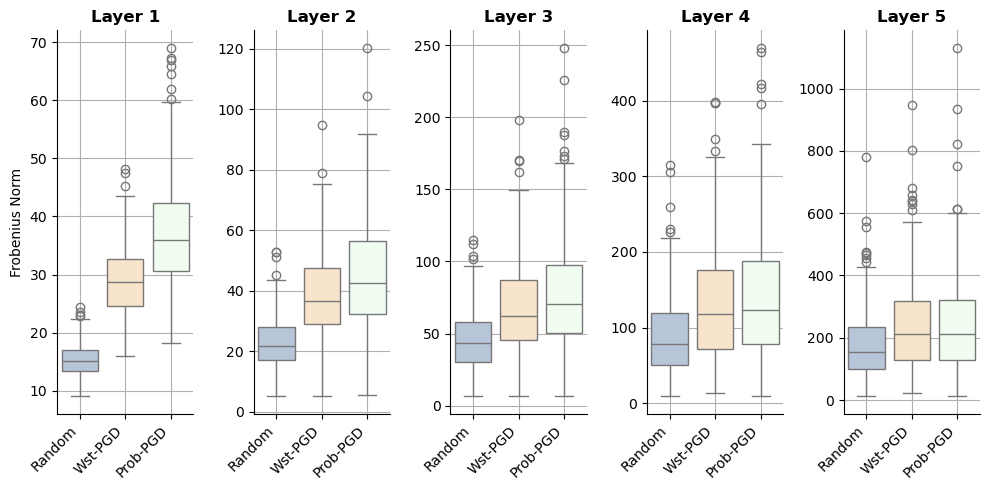

In [7]:

data_sets = {
    "Layer 1": [X1p_random_relu, X1p_pgd_wst_relu, X1p_pgd_avg_relu],
    "Layer 2": [X2p_random_relu, X2p_pgd_wst_relu, X2p_pgd_avg_relu],
    "Layer 3": [X3p_random_relu, X3p_pgd_wst_relu, X3p_pgd_avg_relu],
    "Layer 4": [X4p_random_relu, X4p_pgd_wst_relu, X4p_pgd_avg_relu],
    "Layer 5": [X5p_random_relu, X5p_pgd_wst_relu, X5p_pgd_avg_relu],
}

labels = ['Random', 'Wst-PGD',  'Prob-PGD']
colors = ['lightsteelblue', 'bisque', 'honeydew']

fig, axes = plt.subplots(1, len(data_sets), figsize=(10, 5))
for ax, (layer, data) in zip(axes, data_sets.items()):
    sns.boxplot(data=data, palette=colors, ax=ax)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=10, rotation=45, ha='right')
    ax.set_title(f"{layer}", fontsize=12, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    if layer == "Layer 1":
        ax.set_ylabel("Frobenius Norm", fontsize=10)

plt.tight_layout()
# for i, layer in enumerate(data_sets.keys()):
    # plt.savefig(f"Layer_{i+1}_Frobenius_Norm.pdf", bbox_inches='tight', pad_inches=0.1)
# plt.show()


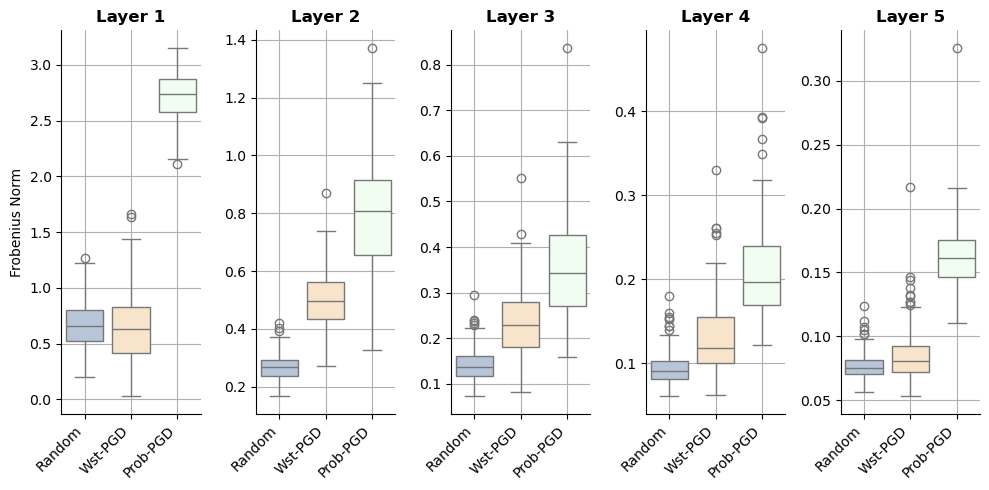

In [8]:

data_sets = {
    "Layer 1": [X1p_random_sigmoid, X1p_pgd_wst_sigmoid, X1p_pgd_avg_sigmoid],
    "Layer 2": [X2p_random_sigmoid, X2p_pgd_wst_sigmoid, X2p_pgd_avg_sigmoid],
    "Layer 3": [X3p_random_sigmoid, X3p_pgd_wst_sigmoid, X3p_pgd_avg_sigmoid],
    "Layer 4": [X4p_random_sigmoid, X4p_pgd_wst_sigmoid, X4p_pgd_avg_sigmoid],
    "Layer 5": [X5p_random_sigmoid, X5p_pgd_wst_sigmoid, X5p_pgd_avg_sigmoid],
}

labels = ['Random', 'Wst-PGD',  'Prob-PGD']
colors = ['lightsteelblue', 'bisque', 'honeydew']

fig, axes = plt.subplots(1, len(data_sets), figsize=(10, 5))
for ax, (layer, data) in zip(axes, data_sets.items()):
    sns.boxplot(data=data, palette=colors, ax=ax)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=10, rotation=45, ha='right')
    ax.set_title(f"{layer}", fontsize=12, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    if layer == "Layer 1":
        ax.set_ylabel("Frobenius Norm", fontsize=10)

plt.tight_layout()
# for i, layer in enumerate(data_sets.keys()):
    # plt.savefig(f"Layer_{i+1}_Frobenius_Norm.pdf", bbox_inches='tight', pad_inches=0.1)
# plt.show()


/var/folders/g5/2bq04cqs5_ndzg2hlc5lx8dr0000gr/T/ipykernel_46524/3351349381.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


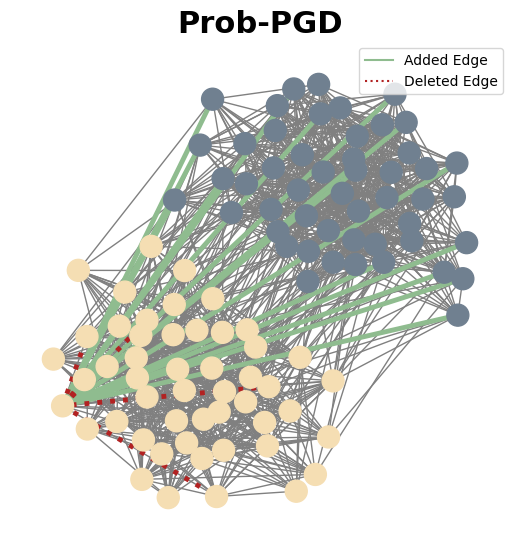

In [9]:
A_modified = A_pgd_avg
A_original = A_SBM

# Find the differences between the original and modified matrices
diff_matrix = A_modified - A_original

  # Create a list to store edges to be highlighted
edges_to_highlight = []
for i in range(diff_matrix.shape[0]):
    for j in range(i + 1, diff_matrix.shape[1]):  # Iterate over upper triangle
        if diff_matrix[i, j] == 1:  # Added edge
            edges_to_highlight.append((i, j, 'added'))
        elif diff_matrix[i, j] == -1:  # Deleted edge
            edges_to_highlight.append((i, j, 'deleted'))

# Visualize the graph with highlighted edges
plt.figure(figsize=(5, 5))
node_colors = [G.nodes[node]['label'] for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=cmap, node_size=250, edge_color='gray', with_labels=False)

# Highlight modified edges
for u, v, edge_type in edges_to_highlight:
    if edge_type == 'added':
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='#8FBC8F', width=3.5)
    elif edge_type == 'deleted':
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='#B22222', style=':', width=3.5)

added_edge_line = mlines.Line2D([], [], color='#8FBC8F', label='Added Edge', linestyle='-')
deleted_edge_line = mlines.Line2D([], [], color='#B22222', label='Deleted Edge', linestyle=':')
plt.legend(handles=[added_edge_line, deleted_edge_line])
plt.title('Prob-PGD', fontsize = 22, fontweight = 'bold')
plt.tight_layout()
plt.savefig("GIN_avg.pdf",bbox_inches='tight', pad_inches=0.1)
plt.show()


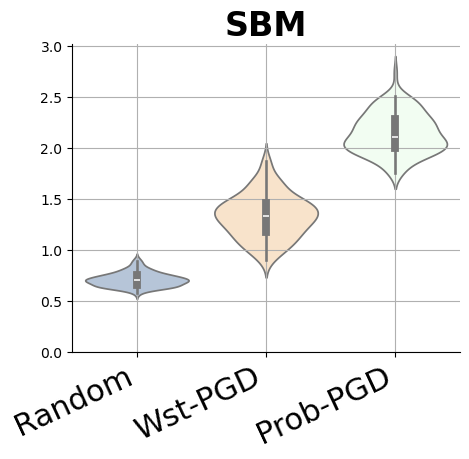

Random attack: embedding perturbation (theory): 0.51, embedding perturbation (sample):0.51 
Wst-PGD attack: embedding perturbation (theory): 1.83, embedding perturbation (sample):1.83 
Prob-PGD attack: embedding perturbation (theory): 4.64, embedding perturbation (sample):4.64 


In [10]:
#  filter = 'adj_norm' vaildation
D_inv_sqrt = torch.diag(torch.pow(torch.sum(A, dim=1), -0.5))
D_inv_sqrt = torch.nan_to_num(D_inv_sqrt, posinf=0, neginf=0) 
A_norm = torch.matmul(torch.matmul(D_inv_sqrt, A), D_inv_sqrt)  

D_inv_sqrt_random = torch.diag(torch.pow(torch.sum(A_random, dim=1), -0.5))
D_inv_sqrt_random = torch.nan_to_num(D_inv_sqrt_random, posinf=0, neginf=0)
A_norm_random = torch.matmul(torch.matmul(D_inv_sqrt_random, A_random), D_inv_sqrt_random)

D_inv_sqrt_pgd_avg = torch.diag(torch.pow(torch.sum(A_pgd_avg, dim=1), -0.5))
D_inv_sqrt_pgd_avg = torch.nan_to_num(D_inv_sqrt_pgd_avg, posinf=0, neginf=0)
A_norm_pgd_avg = torch.matmul(torch.matmul(D_inv_sqrt_pgd_avg, A_pgd_avg), D_inv_sqrt_pgd_avg)


D_inv_sqrt_pgd_wst = torch.diag(torch.pow(torch.sum(A_pgd_wst, dim=1), -0.5))
D_inv_sqrt_pgd_wst = torch.nan_to_num(D_inv_sqrt_pgd_wst, posinf=0, neginf=0)
A_norm_pgd_wst = torch.matmul(torch.matmul(D_inv_sqrt_pgd_wst, A_pgd_wst), D_inv_sqrt_pgd_wst)
delta_x_random = np.zeros(d)
delta_x_pgd_avg = np.zeros(d)
delta_x_pgd_wst = np.zeros(d)
for j in range(d):
  delta_x_random[j] = torch.norm(((A_norm-A_norm_random) ) @ X[:,j], p ='fro').item()
  delta_x_pgd_avg[j] = torch.norm(((A_norm-A_norm_pgd_avg) ) @ X[:,j], p ='fro').item()
  delta_x_pgd_wst[j] = torch.norm(((A_norm-A_norm_pgd_wst) ) @ X[:,j], p ='fro').item()


data = [delta_x_random, delta_x_pgd_wst, delta_x_pgd_avg]
labels = ['Random', 'Wst-PGD', 'Prob-PGD']
colors = ['lightsteelblue', 'bisque', 'honeydew']

plt.figure(figsize=(5, 4))
sns.violinplot(data=data, palette=colors)
plt.ylim(0, None)
plt.xticks(range(len(labels)), labels, fontsize = 22,rotation=25, ha='right')
plt.title("SBM",fontsize = 24,fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True)
plt.show()
theory_random = (Attack_GCN.obj_avg(abs(A-A_random)).item())
print(f'Random attack: embedding perturbation (theory): {theory_random:.2f}, embedding perturbation (sample):{np.mean(delta_x_random**2):.2f} ')
theory_pgd_wst = (Attack_GCN.obj_avg(abs(A-A_pgd_wst)).item())
print(f'Wst-PGD attack: embedding perturbation (theory): {theory_pgd_wst:.2f}, embedding perturbation (sample):{np.mean(delta_x_pgd_wst**2):.2f} ')
theory_pgd_avg = (Attack_GCN.obj_avg(abs(A-A_pgd_avg)).item())
print(f'Prob-PGD attack: embedding perturbation (theory): {theory_pgd_avg:.2f}, embedding perturbation (sample):{np.mean(delta_x_pgd_avg**2):.2f} ')

